In [1]:
import random
import hashlib
import pylab
import numpy as np

# Scalable Jaccard neighbour finding

## Jaccard clustering

A standard technique of handling document similarity or clustering is to tokenize the data, and then cluster on the tokens of each document. On small scales, this is relatively easy to get running in a notebook environment.

A tokenizer maps each document to a set of tokens

$ t : d_i \rightarrow \{t(d_i)_j\}_{j=1}^{n_i} = \{t_{ij}\}_{j=1}^{n_i}$

A tokenizer can be as elaborate or as simple as one wishes. Perhaps the simplest is breaking up a document over sentences.

In [2]:
docs = ["I am a fish", "a fish swims"]
tokenized_docs = [x.split(" ") for x in docs]
print(tokenized_docs)

[['I', 'am', 'a', 'fish'], ['a', 'fish', 'swims']]


Using the tokens, one can estimate how similar documents might be. A typical way of seeing the similarity is by a Jaccard similarity. This looks at (between a pair of documents) the number of common tokens divided by the number of all tokens

$ J_{sim}(d_x, d_y) = \frac{|\{t_{xj}\}_{j=1}^{n_x} \cap \{t_{yj}\}_{j=1}^{n_y}|}{|\{t_{xj}\}_{j=1}^{n_x} \cup \{t_{yj}\}_{j=1}^{n_y}|} $

In [3]:
def jaccard_sim(d_x, d_y):
    return len(set(d_x) & set(d_y)) / len(set(d_x) | set(d_y))

For identical sets, the Jaccard similarity will be 1. For sets with no tokens in common, the similarity will be 0. For sets with some tokens in common, the similarity will be between 0 and 1

In [4]:
jaccard_sim(tokenized_docs[0], tokenized_docs[0])

1.0

In [5]:
jaccard_sim(tokenized_docs[0], tokenized_docs[1])

0.4

From the similarity, one can define a distance, the Jaccard distance by

$J_{dist}(d_x, d_y) = 1 - J_{sim}(d_x, d_y)$.

This distance function forms a proper metric [[1]](https://en.wikipedia.org/wiki/Metric_space), i.e. it observes the distance function rules:
- $ J_{dist}(d_x, d_x) = 0 $
- $ J_{dist}(d_x, d_y) > 0 \textrm{  for  } d_x \neq d_y $
- $ J_{dist}(d_x, d_y) = J_{dist}(d_y, d_x) $
- $ J_{dist}(d_x, d_z) \leq J_{dist}(d_x, d_y) + J_{dist}(d_y, d_z) $

which means that the distance metric can legitimately be used for clustering. One can play the usual games with hierarchical clustering etc. In particular, for simple clustering, one can find a documents neighbours by thresholding on the distance, and describing the neighbours of a document as the other documents with a threshold distance $T$ of that document:

$ \textrm{neighbours}(d_i) = \{d_j | J_{dist}(d_i, d_j) < T \}$ 

In [6]:
def neighbours(this_doc, all_docs, threshold, tokenizer=lambda x: x.split(" ")):
    this_tokenized_docs = tokenizer(this_doc)
    all_tokenized_docs = [tokenizer(x) for x in all_docs]
    neighbours = [y[0] for y in zip(all_docs, all_tokenized_docs) if (1 - jaccard_sim(y[1], this_tokenized_docs)) < threshold]
    return neighbours

In [7]:
neighbours("I am a fish", docs, 0.1)

['I am a fish']

In [8]:
neighbours("I am a fish", docs, 0.7)

['I am a fish', 'a fish swims']

The simple implementations above work well for small datasets. However, for large datasets, the computation of distances, or finding nearest neighbours, is $O(N^2)$ where $N$ is the number of documents. Depending on how the results are stored, storage can also be a $N^2 $ problem.

## Upscaling to larger datasets

The approach above (up to some approximations) can be replaced by $O(N)$ operations. The approach is described at a high technical level in [[2]](https://en.wikipedia.org/wiki/Locality-sensitive_hashing). A good in-depth technical overview of everything in this notebook (and then some) is excellently presented in [[8]](http://www.mmds.org/). The idea is that rather than trying to perform nearest neighbour on all the tokenized documents $O(N^2)$, one can try and do an intensive operation on all the documents to a small hash ($O(N)$ in compute, and a small $O(N)$ in storage), and then perform nearest neighbour from the hashes. Computing neighbours by comparing hashes is an extremely cheap $O(N^2)$ operation, so that it is effectively $O(1)$ when compared to all other processing.

Whilst the overall theoreticl approach is called Locality-sensitive hashing (LSH), in implementation circles, the implementations come down to a hashing mechanism to statistically reproduce the distance (e.g. minhash for Jaccard [[3]](https://en.wikipedia.org/wiki/MinHash) [[5]](https://www.youtube.com/watch?v=96WOGPUgMfw), or simhash for cosine [[4]](https://en.wikipedia.org/wiki/SimHash)) and a way of implementing a threshold (rows and bands in a LSH scheme [[6]](https://www.youtube.com/watch?v=_1D35bN95Go)).

## Minhash

The name minhash comes from the fact that one is performing a minimum over hashes. The idea behind the calculation is to calculate an integer (which will be a bucket index) that can be used to estimate the Jaccard similarity. Since this integer is a far smaller piece of information than the original document, the estimation is 'lossy', or more precisely (since the hashing operation is random) statistically represents the Jaccard similarity.

The idea comes down to performing some kind of one-hot encoding, and using the encoding to form 'buckets' of data. A populated bucket can then be chosen at random to see if there is a match between a pair of documents. For instance, take the example of documents

In [9]:
docs

['I am a fish', 'a fish swims']

These can be label-encoded using a scheme (which is a form of tokenizer)

In [10]:
label_scheme = {
    "I": 0,
    "am": 1,
    "a": 2,
    "fish": 3,
    "swims": 4
}
label_encoded_docs = [[label_scheme[y] for y in x.split(" ")] for x in docs]
print(label_encoded_docs)

[[0, 1, 2, 3], [2, 3, 4]]


One can now choose one of the labels (at random, by considering a uniform random variable over all labels) and see if that label appears in each of the encoded documents. The probability of a randomly chosen label appearing in both encoded documents is the number of common labels, divided by all possible labels. This probability is precisely the Jaccard similarity. One therefore finds, that taking a random variable $L \sim U[\textrm{all labels}]$

$P[l \in t(d_x) \cap l \in t(d_y)] = J_{sim}(d_x, d_y)$

In [11]:
all_labels = list(set(sum(label_encoded_docs, [])))
# common_labels = [x for x in all_labels if x in label_encoded_docs[0] and x in label_encoded_docs[1]]
# print(f"probability of a randomly chosen label common in both docs = {len(common_labels)/len(all_labels)}")

n_sample = 1000
common_label_hits = 0
for i_sample in range(n_sample):
    label = random.choices(all_labels)[0]
    if label in label_encoded_docs[0] and label in label_encoded_docs[1]:
        common_label_hits += 1
print(f"empirical probability of randomly chosen label being common = {common_label_hits/n_sample}")

empirical probability of randomly chosen label being common = 0.421


This is the principal behind minhashing, although the implementation is a little different to accommodate an arbitrary number of documents, rather than the toy example of two documents above. In minhash lingo, one thinks of 'buckets' instead of 'labels', where each label is an index to a bucket that a document can be 'dropped into'.

Minhashing usually using a text tokenizer called 'shingling'. However, one can use any tokenizer, and can use the same tokenizer one may have used in the small scale pure Jaccard analysis one may have done.

In [12]:
def get_minhashed_docs(tokenized_docs):
    # convert text tokens into 32 bit integers
    def str_to_int(s):
        return int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % 2 ** 31
    int_tokenized_docs = [[str_to_int(y) for y in x] for x in tokenized_docs]
    # optimization tip; the code below totally flies with numba
    # using random numbers that fit into 32 bit integers, since then multiplicative arithmetic will be
    #   valid over 64 bit integers, in case one needs a true fixed point implementation
    # generate a random hash. The random choice of hash marries up to the idea above of
    #   choosing a random label/bucket ...
    a, b = random.randint(1, 2 ** 31), random.randint(1, 2 ** 31) 
    big_prime_number = 7919  # modulo by a prime number, as opposed to any other number,
                             # since this guarantees that 'a' and 'p' are coprime,
                             # which helps minimize collisions, and get more coverage over the buckets
    p = big_prime_number
    random_hashed_docs = [[(a * y + b) % p for y in x] for x in int_tokenized_docs]
    # ... since a different random hash will pull out a different label/bucket under the min operation
    minhashes = [min(x) for x in random_hashed_docs]
    return minhashes
 
for _ in range(10):
    print(get_minhashed_docs(tokenized_docs))

[1208, 1208]
[1025, 962]
[3545, 1942]
[868, 1725]
[1798, 1798]
[2345, 2484]
[3491, 3635]
[1854, 1854]
[1183, 5638]
[2045, 5956]


In the above, sometimes the two minhashes are the same, and sometimes they are different. When they are the same, this corresponds to the min operation in the get_minhashed_function pulling out a hash corresponding to a common token. When they are different, the min has pulled out hashes corresponding to different tokens. From the same reasoning as the simple label encoding example above, one has

$P[\textrm{minhash}(t(d_x)) = \textrm{minhash}(t(d_y))] = J_{sim}(d_x, d_y)$

where (under a slight abuse of notation), the minhash function on a document is a random variable, and the same random hash is used on $d_x$ and $d_y$.

The size of the prime number, $p$, used in the minhash operation is worthy of consideration. All tokens will be mappers to an integer in $[0, p-1]$. This means that if $p$ is too small, the likelihood of a collision is quite high. A common rule of thumb for choosing $p$ is a prime number that is slightly large than $y$ in the formula above. One can sometimes choose a smaller $p$, by choosing a prime that allows a suitably small chance of a hash collision, e.g. a prime that is an order of magnitude larger than the size of the tokenized corpus.

In [13]:
n_sample = 1000
common_label_hits = 0
for i_sample in range(n_sample):
    # generating n_sample minhash integers per document, which can be thought of
    # as generating a (minhash) vector of n_sample integers per document
    minhashed_docs = get_minhashed_docs(tokenized_docs)
    if minhashed_docs[0] == minhashed_docs[1]:
        common_label_hits += 1
print(f"empirical probability of minhashes being the same = {common_label_hits/n_sample}")

empirical probability of minhashes being the same = 0.401


In the above, the minhashing operation has been performed over only 2 documents, but there is nothing to stop running the operation over $N$ documents to generate a minhash for each doc, and then check for equalities in the resulting minhashes.

Each set of minhashes is a realisation of a random variable (a choice of randomly selected $a, b$ above). In this sense, the neighbour checking is statistical, and only an approximate nearest neighbour.

The hashing process is also a lossy operation. Taking n_sample to be small yields a poor approximation to the Jaccard similarity. However, taking n_sample to be large means that a large amount of processing has to occur, yielding long minhash vectors, partially negating the benefit if using minhashing for computational and storage gain. The choice of minhash vector length (i.e. n_sample) really feeds into the LSH scheme, but generally does reflect 'how approximate' the approximate nearest neighbour approach will be.

## Locality-sensitive hashing

In the above analysis, there is a function that takes tokenized documents to minhash vectors. These minhash vectors are statistical samples representing the Jaccard similarity between the referenced documents, and can be used to (statistically) estimate the Jaccard similarity.

However, to declare if a pair of documents are neighbours, one must apply a threshold to the Jaccard similarity. This is accomplished using 'rows and bands' over the minhash vectors. The underlying idea is that requiring more of the minhashes (over the minhash vector) to be equal puts a stronger constraint on saying when two documents are neighbours, and therefore corresponds to a tighter/smaller threshold on the Jaccard distance.

The LSH rows-and-bands approach is in fact a general approach for applying a threshold to a hashing scheme, and the same idea can be applied to minhash vectors, simhash vectors or Hamming-bit-wise vectors. The minhash vectors (of length n_samples) are split into 'b' bands, with each band containing 'r' rows (i.e. n_samples = $r \times b$). Whether or not a pair of documents are considered as neighbours then comes down to whether or not there is a band where all minhashes match [[9]](http://csce.uark.edu/~lz006/course/2022fall/05-lsh.pdf) (in the digram below, each vertical slice corresponds to a minhash vector, and the horizontal axis scrolls over documents).

![rows and bands pic](rows-and-bands.png)

In the extreme cases, where there is only one band, $b=1$, this corresponds to the case where all minhashes across the minhash vector need to match for a pair of documents to be neighbours; this would correspond to a tight/small threshold on the Jaccard distance. On the other hand, when there is only one row per band, $b=$ n_sample, then only one minhash across a pair of minhash vectors needs to match; this would correspond to a loose/large threshold on the Jaccard distance. Remember that each row corresponds to a particular realisation of a minhash random variable (in the sense that they correspond to a particular value of 'a' and 'b' used in the hash), and so different bands have no shared context, i.e. the numbers in, say, band 3 have nothing to do with the numbers in band 2.

The calculations needed can be captured by performing another hashing operation that takes the minhash vectors and converts them to LSH vectors.

In [14]:
def get_lsh_docs_from_minhashed_docs(minhashed_docs, n_bands, n_rows):
    assert len(minhashed_docs) == n_bands * n_rows
    lsh_docs = []
    for i_band in range(n_bands):
        a, b = random.randint(1, 2 ** 31), random.randint(1, 2 ** 31)
        buckets = 2 ** 64 - 59  # so hash will fit in an uint64 and number of buckets is prime
        these_docs = minhashed_docs[(i_band * n_rows):(i_band * n_rows) + n_rows]
        this_band_lsh_docs = []
        for i_doc in range(len(these_docs[0])):
            # for this doc, make a single number, via string concatenation,
            # out of all the minhashes in the band; this will concatenate n_rows integers
            num_as_str = ""
            for i_row in range(n_rows):
                num_as_str += str(these_docs[i_row][i_doc])
            # make a single hash out of the concatenated number, so that it fits into
            # a reasonably sized number
            this_band_lsh_docs.append((a * int(num_as_str) + b) % buckets)
        lsh_docs.append(this_band_lsh_docs)
    return lsh_docs
            
# 2 docs
minhashed_docs = [get_minhashed_docs(tokenized_docs) for _ in range(12)]  # 12 minhashes per doc
print(*(["minhashed docs: "] + minhashed_docs), sep="\n")
lshed_docs = get_lsh_docs_from_minhashed_docs(minhashed_docs, 3, 4)  # 3 bands, 4 rows in each band
print(*(["", "", "lsh-ed docs: "] + lshed_docs), sep="\n")

minhashed docs: 
[2920, 4539]
[1151, 3465]
[2326, 4917]
[824, 1040]
[266, 675]
[1465, 1465]
[415, 415]
[1398, 1398]
[1780, 1780]
[1294, 1294]
[2774, 4265]
[988, 988]


lsh-ed docs: 
[15429150795541850238, 11367925971555874387]
[5894419285259359387, 2648308545643551940]
[16845985640931665735, 16846882535756603735]


The number of LSH buckets need to be adjusted so that the concatenated minhashes have a suitably small probability of colliding.

The question of whether or not any documents are neighbours then comes down to looking at the LSH vectors, and seeing if, within band, there are any matching LSH numbers that match

In [15]:
def get_neighbours_of_lsh_doc(i_doc, lshed_docs):
    neighbour_docs_indices = set()
    for lsh_row in lshed_docs:
        query_lsh = lsh_row[i_doc]
        matching_docs = {x[0] for x in enumerate(lsh_row) if x[1] == query_lsh}
        neighbour_docs_indices |= matching_docs
    return neighbour_docs_indices

get_neighbours_of_lsh_doc(0, lshed_docs)

{0}

For the loosest case of 1 band in each row, if there are any minhash matches in a row, then there LSH matches

In [16]:
minhashed_docs = [get_minhashed_docs(tokenized_docs) for _ in range(12)]  # 12 minhashes per doc
print(*(["minhashed docs: "] + minhashed_docs), sep="\n")
lshed_docs = get_lsh_docs_from_minhashed_docs(minhashed_docs, 12, 1)  # 12 bands, 1 row
print(f"neighbours of doc 0 = {get_neighbours_of_lsh_doc(0, lshed_docs)}")

minhashed docs: 
[178, 178]
[95, 95]
[3490, 1125]
[537, 4936]
[553, 5753]
[808, 808]
[1028, 1028]
[317, 317]
[2320, 2876]
[511, 1115]
[848, 848]
[2242, 3048]
neighbours of doc 0 = {0, 1}


For 2 rows, if any pair of docs have all 2 minhashes in a band matching, then they are picked up as LSH neighbours

In [17]:
lshed_docs = get_lsh_docs_from_minhashed_docs(minhashed_docs, 6, 2)  # 6 bands, 2 rows
print(f"neighbours of doc 0 = {get_neighbours_of_lsh_doc(0, lshed_docs)}")

neighbours of doc 0 = {0, 1}


For 1 band, all minhashes have to match between a pair of documents for the documents to be LSH neighbours

In [18]:
lshed_docs = get_lsh_docs_from_minhashed_docs(minhashed_docs, 1, 12)  # 1 band, 12 rows
print(f"neighbours of doc 0 = {get_neighbours_of_lsh_doc(0, lshed_docs)}")

neighbours of doc 0 = {0}


### Relating rows and bands to a Jaccard threshold

The entire LSH process is a statistically based approximate nearest neighbour process. The probability of a pair of minhashes matching is precisely the Jaccard similarity $s$ between those two documents. Following [[9]](http://csce.uark.edu/~lz006/course/2022fall/05-lsh.pdf), one can calculate, from the number of rows $r$ and the number of bands $b$:

Probability all rows in a band equal = $s^r$

Probability of a row mismatch in a band (and hence that this band's LSH does not match) = $1 - s^r$ 

Probability that all LSHs do not match = $(1 - s^r)^b$

Probability that there is an LSH match (and hence that LSH finds the two documents ar neighbours) = $ 1 - (1 - s^r)^b$

For a particular $r$ and $b$, one can plot the probability of an LSH match as a function of the Jaccard similarity between two documents (which is the probability of the documents having the same minhash)

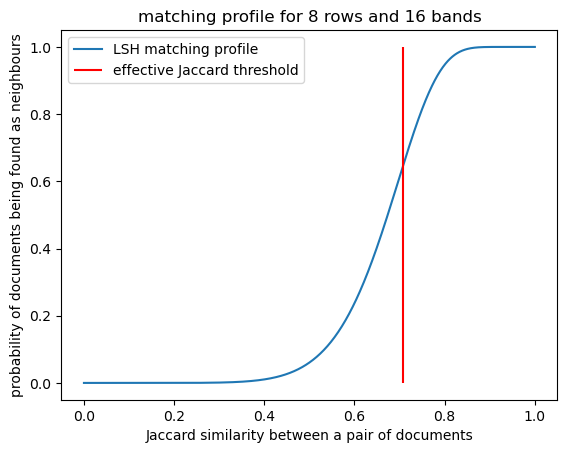

In [19]:
def plot_lsh_matching_prob_against_jaccard_sim(n_rows, n_bands):
    s = np.arange(1001)/1000
    lsh = 1.0 - (1.0 - s ** n_rows) ** n_bands
    effective_jaccard_threshold = (1 / n_bands) ** (1 / n_rows)
    pylab.plot(s, lsh, label="LSH matching profile")
    pylab.vlines(x = effective_jaccard_threshold, ymin = 0, ymax = 1, colors="red", label="effective Jaccard threshold")
    pylab.xlabel("Jaccard similarity between a pair of documents")
    pylab.ylabel("probability of documents being found as neighbours")
    pylab.title(f"matching profile for {n_rows} rows and {n_bands} bands")
    pylab.legend()

plot_lsh_matching_prob_against_jaccard_sim(8, 16)

Some important aspects to note are:
- the curve is a smooth curve. For a threshold one would ideally want a step function. As the number of minhashes increases, the curve becomes more like a step function. This is a reflection of the statistical fact that more minhashes makes a better statistical estimator, as noted in the minhash section above. However, the curve never becomes a step function, meaning there will always be false positives and negatives. This is a statistical representation of the fact that this is an approximate nearest neighbour algorithm
- One can 'move' the steepest part of the curve left and right by keeping $r \times b$ fixed, and changing $r$ and $b$. This corresponds to changing the Jaccard threshold on the similarity, as alluded to in the matching examples above of 1 row or 1 band.
- Saying precisely what the effective Jaccard similarity threshold is nebulous, since this means choosing a point on the curve. The steepest part of the curve is around $s^* \approx \left(\frac{1}{b}\right)^\frac{1}{r} $. The effective Jaccard distance threshold is thus $d^* = 1 - s^* \approx 1 - \left(\frac{1}{b}\right)^\frac{1}{r} $

The standard approach of an LSH scheme design builds up a number of rows and bands based on acceptable false alarm rates, and the required threshold. One can, however, turn this on its head, and for a minhash table of minhash vectors, work with all possible LSH schemes (i.e. all possible rows and bands) to find the approx nearest neighbours for each LSH scheme. Since each LSH scheme corresponds to a different effective Jaccard threshold, one is effectively performing clustering at multiple Jaccard thresholds. This effectively permits scalable hierarchical clustering.

## Storage of hashes

In [20]:
def storage_in_bytes(n_docs, n_hashes):
    int64_bytes = 8
    return int64_bytes * n_docs * n_hashes

One can estimate the size of the minhash table and lst table in memory. For instance, with 1000000 documents a length 128 minhash, and an LSH scheme with 16 bands, one has:

In [21]:
print(f"minhash table occupies {storage_in_bytes(1000000, 128)/1000000} MB")
print(f"LSH table occupies {storage_in_bytes(1000000, 16)/1000000} MB")

minhash table occupies 1024.0 MB
LSH table occupies 128.0 MB


If one only wishes to do direct approx nearest neighbours, only the LSH table needs to persist. If one wishes to run multiple LSH schemes, either multiple LSH tables need to be stored, or the minhash table needs to be stored.

In the pure LSH case, even for a reasonable sized database of a million records, the LSH table will easily fit in memory.

Since the minhash/lsh hashing is performed on a per-document level, this process can form a part of a data ingest/ETL operation, and old records being removed corresponds to the relevant hashes being removed.

## References

[1] https://en.wikipedia.org/wiki/Metric_space

[2] https://en.wikipedia.org/wiki/Locality-sensitive_hashing

[3] https://en.wikipedia.org/wiki/MinHash

[4] https://en.wikipedia.org/wiki/SimHash

[5] https://www.youtube.com/watch?v=96WOGPUgMfw

[6] https://www.youtube.com/watch?v=_1D35bN95Go

[7] https://arxiv.org/abs/1809.04052 - Ryan Moulton, Yunjiang Jiang, "Maximally Consistent Sampling and the Jaccard Index of Probability Distributions"

[8] http://infolab.stanford.edu/~ullman/mmds/book0n.pdf - Jure Leskovec, Anand Rajaraman, Jeffrey D. Ullman, "Mining of massive datasets"

[9] http://csce.uark.edu/~lz006/course/2022fall/05-lsh.pdf - Jure Leskovec, "Finding Similar Items &
Locality Sensitive Hashing"

## Appendix - Jaccard distance triangle inequality

Using

$J_{dist}(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cup B| - |A \cap B|}{|A \cup B|}$

many of the properties required for $J_{dist}$ are easy to see, e.g.
- $J_{dist}(A, A) = 0$
- $J_{dist}(A, B) > 0$ for $A\neq B$
- $J_{dist}(A, B) = J_{dist}(B, A)$

However the triangle inequality is not quite so obvious. Using the statistical representation of the Jaccard distance as a minhash H, this becomes a little easier using properties of probabilities [[7]](https://arxiv.org/abs/1809.04052). First, note that

$ J_{sim}(A, B) = P[H(A) = H(B)]$

$ J_{dist}(A, B) = 1 - P[H(A) = H(B)] = P[H(A) \neq H(B)]$

Introducing a third set $C$, one has

$ P[H(A) = H(B)] \geq P[H(A) = H(B) = H(C)] = P[H(A) = H(C) \cap H(C) = H(B)]$

and therefore, by negating the above statement,

$ P[H(A) \neq H(B)] \leq P[H(A) \neq H(C) \cup H(C) \neq H(B)]$.

Now, by $P[X\cup Y] = P[X] + P[Y] - P[X\cap Y]$, 

$P[H(A) \neq H(C) \cup H(C) \neq H(B)] = P[H(A) \neq H(C)] + P[H(C) \neq H(B)] - P[H(A) \neq H(C) \cap H(C) \neq H(B)]$

and therefore 

$P[H(A) \neq H(C) \cup H(C) \neq H(B)] \leq P[H(A) \neq H(C)] + P[H(C) \neq H(B)] $

Combining the two inequalities above, one finds that

$ P[H(A) \neq H(B)] \leq P[H(A) \neq H(C)] + P[H(C) \neq H(B)]$

which is the same as

$ J_{dist}(A, B) \leq J_{dist}(A, C) + J_{dist}(C, B) $

hence expressing the triangle inequality.